In [1]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.coordinates import SkyCoord
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.daf.butler import Butler
# from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable

In [2]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
# These are the collections containing the Y1 processed visit images, etc..
collections = ['u/taceroc/custom_coadd_test_3_422025',
               'u/taceroc/custom_coadd_test_2_442025',
               'u/taceroc/test_LEinjection_inputs_2_432025_custom_coadd_test_3_422025',
               'u/taceroc/test_LEinjection_inputs_1_442025_custom_coadd_test_2_442025'
              ]

In [3]:
butler = Butler(repo, collections=collections)

In [4]:
injection_refs = butler.registry.queryDatasets("injection_catalog")
# injection_catalogs = [
#     calexp_butler.get(injection_ref) for injection_ref in injection_refs
# ]

In [41]:
injection_catalogs = [
    butler.get(injection_ref) for injection_ref in injection_refs
]

In [42]:
injection_catalogs[1]

injection_id,ra,dec,source_type,mag,stamp
int64,float64,float64,str5,int64,str102
9999,53.71,-28.68,Stamp,24,"fits/surface_valuesInfPlane_dt0_loop_ct230_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits"


In [43]:
injection_catalogs[0]

injection_id,ra,dec,source_type,mag,stamp
int64,float64,float64,str5,int64,str102
9999,53.71,-28.68,Stamp,24,"fits/surface_valuesInfPlane_dt0_loop_ct165_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits"


In [44]:
injection_catalogs[0]['mag'] = 22
# injection_catalogs[0]['stamp'] = 'fits/surface_valuesInfPlane_dt0_loop_ct665_loc[2, 1.3, 1, -163.078]_dz0.06_w673_angle[150, 220].fits'

In [45]:
injection_catalogs[1]['mag'] = 22
# injection_catalogs[1]['stamp'] = 'fits/surface_valuesInfPlane_dt0_loop_ct730_loc[2, 1.3, 1, -163.078]_dz0.06_w673_angle[150, 220].fits'


In [46]:
coadds_refs = butler.registry.queryDatasets("deepCoadd")


In [47]:
list(coadds_refs)

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_3_422025/20250402T165424Z', id=f47ba585-ce1a-47b2-9e7c-c70fa191317f),
 DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_2_442025/20250404T182024Z', id=63fc527d-54e0-4203-9080-31287c23b4fe)]

In [48]:
coadds_catalogs = [
    butler.get(coadds_ref) for coadds_ref in coadds_refs
]

In [49]:
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

# coadd = coadds_catalogs[0]
psf = coadds_catalogs[0].getPsf()
photo_calib = coadds_catalogs[0].getPhotoCalib()
wcs = coadds_catalogs[0].getWcs()

injected_output_1st = inject_task.run(
    injection_catalogs=injection_catalogs[0],
    input_exposure=coadds_catalogs[0].clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure_1st = injected_output_1st.output_exposure
injected_catalog_1st = injected_output_1st.output_catalog

In [50]:
coadds_catalogs[1]

In [51]:
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

# coadd = coadds_catalogs[1]
psf = coadds_catalogs[1].getPsf()
photo_calib = coadds_catalogs[1].getPhotoCalib()
wcs = coadds_catalogs[1].getWcs()

injected_output_2nd = inject_task.run(
    injection_catalogs=injection_catalogs[1],
    input_exposure=coadds_catalogs[1].clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure_2nd = injected_output_2nd.output_exposure
injected_catalog_2nd = injected_output_2nd.output_catalog

In [52]:
injected_coadd_1st = injected_exposure_1st.clone()
injected_coadd_2nd = injected_exposure_2nd.clone()

# Detection

In [53]:
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



In [54]:
raerr = schema.addField("coord_raErr", type="F")
decerr = schema.addField("coord_decErr", type="F")

Create a container which will be used to record metadata about algorithm execution.

In [55]:
algMetadata = dafBase.PropertyList()

`CharacterizeImageTask` characterizes the image properties (e.g., the PSF).

In [56]:
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)
del config

`SourceDetectionTask` detects sources.

Set the configuration for the detection threshold to 4 (the default for LSST catalogs is 5) in order to detect sub-threshold (faint) sources.
Set the detection threshold type to be `stdev`, which means the threshold is applied to the image's standard deviation.
In other words, this configuration will detect sources at $4\sigma$.

In [57]:
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 5 #let the default
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
del config

`SourceDeblendTask` deblends overlapping sources into "parent" and "child" sources.
No configuration is needed for this tutorial.

In [58]:
sourceDeblendTask = SourceDeblendTask(schema=schema)

`SingleFrameMeasurementTask` measures the properties of the deblended sources. No special configuration is needed for this tutorial.

In [59]:
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)
del config

Create a `SourceTable` called `tab` using the minimal schema. It will hold the output of the analysis in the following section.

Then, as `schema` is no longer needed and a fresh minimal schema is made in Section 5, delete this one.

In [60]:
tab = afwTable.SourceTable.make(schema)
del schema

In [26]:
help(charImageTask)

Help on CharacterizeImageTask in module lsst.pipe.tasks.characterizeImage object:

class CharacterizeImageTask(lsst.pipe.base.pipelineTask.PipelineTask)
 |  CharacterizeImageTask(schema=None, **kwargs)
 |  
 |  Measure bright sources and use this to estimate background and PSF of
 |  an exposure.
 |  
 |  Given an exposure with defects repaired (masked and interpolated over,
 |  e.g. as output by `~lsst.ip.isr.IsrTask`):
 |  - detect and measure bright sources
 |  - repair cosmic rays
 |  - detect and mask streaks
 |  - measure and subtract background
 |  - measure PSF
 |  
 |  Parameters
 |  ----------
 |  schema : `lsst.afw.table.Schema`, optional
 |      Initial schema for icSrc catalog.
 |  **kwargs
 |      Additional keyword arguments.
 |  
 |  Notes
 |  -----
 |  Debugging:
 |  CharacterizeImageTask has a debug dictionary with the following keys:
 |  
 |  frame
 |      int: if specified, the frame of first debug image displayed (defaults to 1)
 |  repair_iter
 |      bool; if Tru

In [ ]:
charImageTask.

In [64]:
result = charImageTask.run(injected_coadd_2nd)

Setting gain to 1


In [65]:
type(result)

lsst.pipe.base.struct.Struct

In [66]:
for k, v in result.getDict().items():
    print(k, type(v))

exposure <class 'lsst.afw.image._exposure.ExposureF'>
sourceCat <class 'lsst.afw.table.SourceCatalog'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
psfCellSet <class 'NoneType'>
characterized <class 'lsst.afw.image._exposure.ExposureF'>
backgroundModel <class 'lsst.afw.math._backgroundList.BackgroundList'>


## Source detection

In [68]:
result = sourceDetectionTask.run(tab, injected_coadd_2nd)

In [69]:
result.numPosPeaks

3796

In [70]:
type(result)

lsst.pipe.base.struct.Struct

In [71]:
for k, v in result.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
factorNeg <class 'float'>
positiveThreshold <class 'lsst.afw.detection.Threshold'>
negativeThreshold <class 'lsst.afw.detection.Threshold'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
sources <class 'lsst.afw.table.SourceCatalog'>


In [72]:
sources = result.sources

## Source debelending and measurement

Run the `SourceDeblendTask` and `SingleFrameMeasurementTask`.

In [73]:
sourceDeblendTask.run(injected_coadd_2nd, sources)

In [74]:
sourceMeasurementTask.run(measCat=sources, exposure=injected_coadd_2nd)

In [75]:
sources = sources.copy(True)

In [78]:
sources.asAstropy()

id,coord_ra,coord_dec,parent,coord_raErr,coord_decErr,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_failed,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_near_edge,base_CircularApertureFlux_flag_badCentroid_near_edge,base_GaussianFlux_flag_badCentroid_near_edge,base_LocalBackground_flag_badCentroid_near_edge,base_PsfFlux_flag_badCentroid_near_edge,base_SdssShape_flag_badCentroid_near_edge,base_Variance_flag_badCentroid_near_edge,slot_Centroid_flag_near_edge,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blendedness_flag_noCentroid,base_Blendedness_flag_noShape,base_SdssShape_xx,slot_Shape

In [17]:
# src_refs = butler.registry.queryDatasets("deepCoadd_meas")
# src_catalog = [butler.get(src_ref) for src_ref in src_refs]

In [18]:
# list(src_refs)

[DatasetRef(DatasetType('deepCoadd_meas', {band, skymap, tract, patch}, SourceCatalog), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_2_442025/20250404T182024Z', id=fb47e7e5-aca5-4c03-badb-9ab31a478fc2)]

In [19]:
# deepCoadd_src = simpleButler.get(list(simpleButler.registry.queryDatasets('deepCoadd_meas'))[0])

In [79]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)

result = alTask.run(injected_coadd_1st, injected_coadd_2nd, sources)

Could not apply source flag: "Field with name 'sky_source' not found"


In [21]:
# older injection: INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_2_432025_custom_coadd_test_3_422025"
# newer injection: INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_1_442025_custom_coadd_test_2_442025"

In [80]:
injection_catalogs[1]['ra'].value[0]*geom.degrees

Angle(53.710000000000001, degrees)

In [81]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

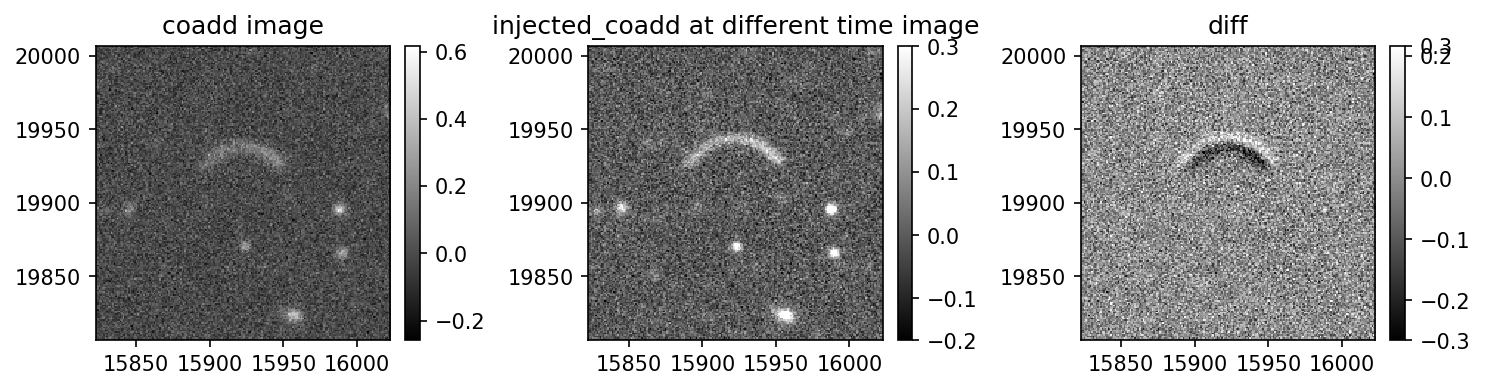

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)
coordiante = wcs.skyToPixel(geom.SpherePoint(injection_catalogs[1]['ra'].value[0]*geom.degrees, injection_catalogs[1]['dec'].value[0]*geom.degrees))

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
# display0.scale('linear', 'zscale')
# display0.scale('linear', min=-0.2, max=0.1)
display0.mtv(injected_coadd_1st.image[coordiante.x+100:coordiante.x-100, coordiante.y+100:coordiante.y-100])
plt.title('coadd image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')

# display0.dot('+', coordiante.x, coordiante.y, size=50, ctype='orange')
display1.mtv(injected_coadd_2nd.image[coordiante.x+100:coordiante.x-100, coordiante.y+100:coordiante.y-100])
plt.title('injected_coadd at different time image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result.difference.image[coordiante.x+100:coordiante.x-100, coordiante.y+100:coordiante.y-100])
plt.title('diff')

plt.tight_layout()
plt.show()

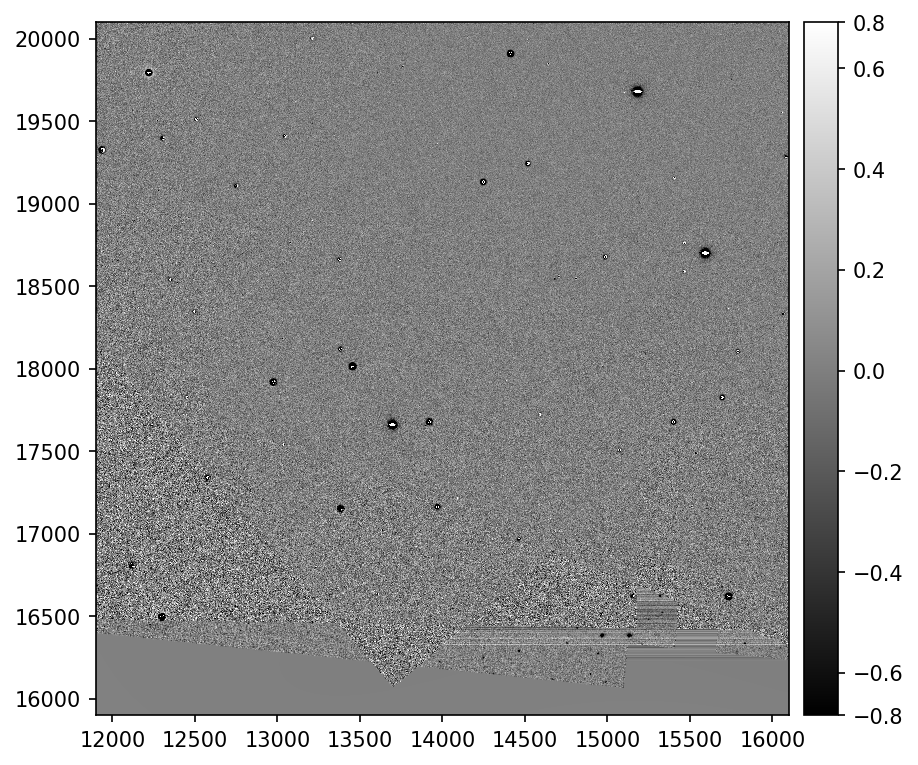

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
coordiante = wcs.skyToPixel(geom.SpherePoint(injection_catalogs[1]['ra'].value[0]*geom.degrees, injection_catalogs[1]['dec'].value[0]*geom.degrees))

display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(result.difference.image)
# display0.dot('+', coordiante.x, coordiante.y, size=50, ctype='orange')


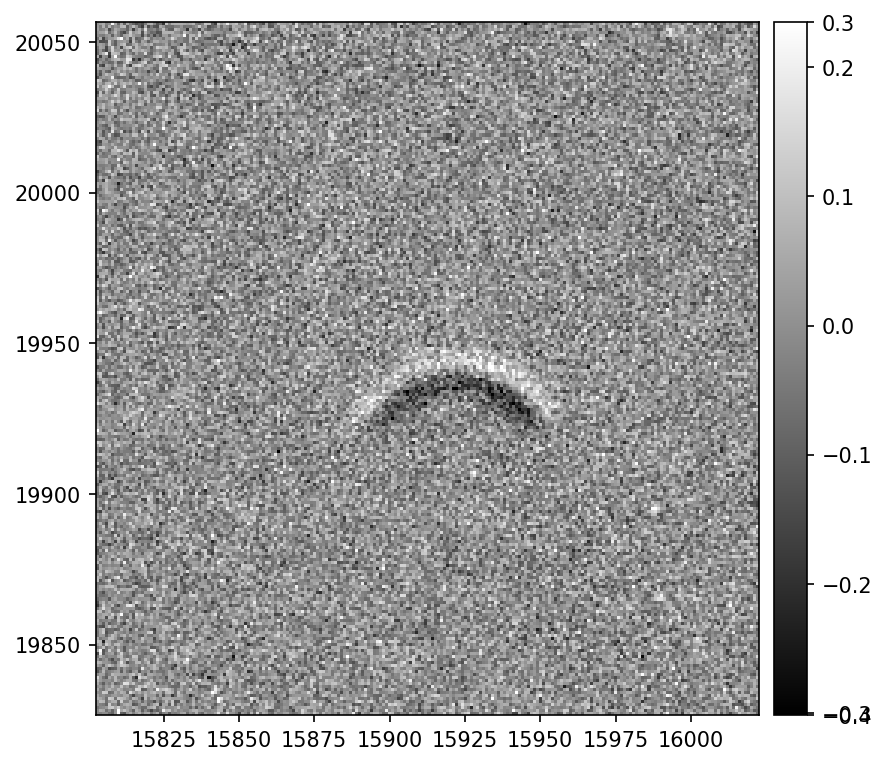

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
# coordiante = wcs.skyToPixel(geom.SpherePoint(injection_catalogs[1]['ra'].value[0]*geom.degrees, injection_catalogs[1]['dec'].value[0]*geom.degrees))

display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(result.difference.image[coordiante.x+100:coordiante.x-120, coordiante.y+150:coordiante.y-80])
# display0.dot('+', coordiante.x, coordiante.y, size=50, ctype='orange')